In [1]:
import ast
import re
import warnings
from typing import List, Union, Dict
from transliterate import translit

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from tqdm.notebook import tqdm

from data_utils import check_missing
from get_metrics import get_metrics_regression

warnings.filterwarnings("ignore")
warnings.simplefilter("ignore", category=RuntimeWarning)
sns.set()

RAND = 10

# Описание задачи

**Цель проекта:** Спарсить данные о фильмах с сайта Кинопоиск, провести их анализ и разработать модель машинного обучения для прогнозирования сборов фильма в США.

**Цель текущего ноутбука:** 
<br>Построение и оценка базовых моделей машинного обучения на подготовленных данных из предыдущих ноутбуков (EDA и Метрики персон). Определить, какие из моделей наиболее перспективные для дальнейшего тюнинга и улучшения качества прогнозирования.

**Основные этапы работы с базовыми моделями:**

**1. Подготовка данных:**
   - Генерация новых признаков, создание и фильтрация dummy-переменных, а также разделение данных на два датасета по годам. 

**2. Выбор моделей для бэйзлайнов:**
   - Определение, какие алгоритмы будут использоваться для создания базовых моделей (например, LGBM, CatBoost).

**3. Обучение моделей и оценка качества:**
   - Обучение выбранных моделей на обучающей выборке и оценка их производительности на тестовой выборке с использованием выбранных метрик.

**4. Анализ переобучения:**
   - Сравнение результатов моделей на обучающей и тестовой выборках для выявления признаков переобучения.

**5. Выводы и рекомендации:**
   - Определение, какие модели являются наиболее перспективными для дальнейшего тюнинга. 

# Импорт данных

In [2]:
df = pd.read_csv('data/movies_main_modified_METRICS_imdb.csv', sep=';')
df = df[df.fees_usa!=0]
df = df.set_index('movie_id')

# Преобразуем колонки в тип список, чтобы создать dummies
for col in ['genres', 'countries', 'Производство', 'Спецэффекты']:
    
    df[col] = df[col].fillna('[]')
    df[col] = df[col].apply(lambda x: x
                            if isinstance(x, list) else ast.literal_eval(x))
    
df.ratingMpaa.fillna('nan', inplace=True)

Описание полей:

- **movie_id** - уникальный идентификатор фильма.
- **movie_name** - название фильма.
- **year** - год выпуска фильма.
- **votes_kp, votes_imdb** - количество оценок фильма на Кинопоиске и IMDB.
- **rating_kp, rating_imdb** - рейтинги фильма на Кинопоиске и IMDB.
- **votes_filmCritics** - количество оценок кинокритиков в мире
- **rating_filmCritics** - рейтинг кинокритиков в мире
- **votes_await** - количество ожидающих фильм на Кинопоиске
- **movieLength** - длина фильма
- **ageRating, ratingMpaa** - возрастные рейтинги фильма
- **type** - тип картины (фильм/мультфильм)
- **genres** - жанры фильма
- **countries** - страны фильма
- **режиссеры, сценаристы, актеры** - имена персон, учавствующих в фильме
- **режиссеры_id, сценаристы_id, актеры_id** - id персон, учавствующих в фильме
- **fees_world, fees_usa, fees_russia** - сборы фильма в мире, США, России
- **fees_world_currency и т.д.** - валюта сборов фильма
- **budget, budget_currency** - бюджет и валюта бюджета фильма
- **videos_trailers_number** - количество трейлеров
- **videos_teasers_number** - количество тизеров
- **Производство** - студии производства
- **Спецэффекты** - студии спецэффектов
- **actor_metric_2019, и т.д.** - метрики персон, полученные в предыдущем ноутбуке

In [3]:
# Первые 5 строк DataFrame - для наглядности транспонируем
df[:5].T

movie_id,535341,1143242,1318972,462682,251733
movie_name,1+1,Джентльмены,Гнев человеческий,Волк с Уолл-стрит,Аватар
year,2011,2019,2021,2013,2009
votes_kp,1678838.0,1524128.0,1154017.0,1125382.0,1014540.0
votes_imdb,895482.0,372380.0,197022.0,1471424.0,1359191.0
votes_filmCritics,130.0,277.0,256.0,289.0,335.0
votes_await,15.0,13642.0,23490.0,43024.0,38689.0
rating_kp,8.813,8.562,7.605,7.976,7.972
rating_imdb,8.5,7.8,7.1,8.2,7.9
rating_filmCritics,6.8,6.5,6.3,7.8,7.4
movieLength,112.0,113.0,119.0,180.0,162.0


In [4]:
df.shape

(5327, 35)

# Распределение целевой переменной

In [5]:
# Прологарифмируем целевую переменную
df['fees_usa_log'] = np.log1p(df.fees_usa)

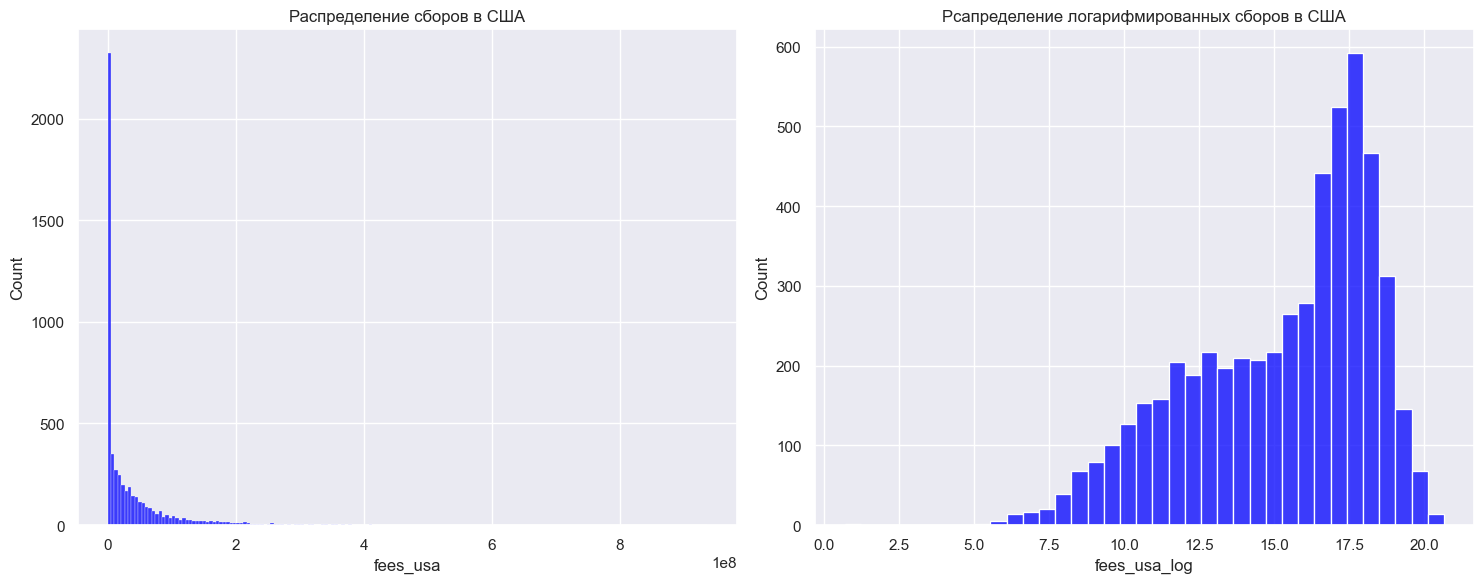

In [6]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

# Первый график для исходной переменной
sns.histplot(df.fees_usa, color='blue', ax=axes[0])
axes[0].set_title('Распределение сборов в США')

# Второй график для логарифмированной переменной
sns.histplot(df.fees_usa_log, color='blue', ax=axes[1])
axes[1].set_title('Рсапределение логарифмированных сборов в США')

plt.tight_layout()
plt.show();

Целевая переменная имеет длинный правый хвост. Распределение асимметричное. 


Для обучения будем использовать логарифмированную переменную, чтобы предсказания сборов не были отрицательными. 

Также используем функцию потерь, устойчивую к выбросам и ненормальному распределению - MAE (Mean Absolute Error)

# Описание бэйзлайнов

Будут протестированы различные комбинации данных. Вот основные критерии для тестирования:


**Данные:**

- до 2020 года
- включая 2020-2023 годы

**Информация до релиза (кол-во оценок и рейтинг неизвестны до релиза):**

- с информацией, известной до релиза 
- без информации, известной до релиза

# Подготовка данных

In [7]:
class DataFrameTransformer:
    """
    Класс для выполнения преобразований над DataFrame.
    Включает в себя добавление новых признаков, 
    бинаризацию колонок и очистку названий колонок.
    """

    def __init__(self, df: pd.DataFrame, year: int, p: float,
                 cols_to_drop: List[str], dummy_cols: List[str]):
        """
        Инициализация класса с dataframe и параметрами преобразования.

        Параметры:
        - df (pd.DataFrame): Входной dataframe.
        - year (int): Текущий год для расчета возраста фильма.
        - p (float): Порог дисперсии для фильтрации бинаризованных колонок.
        - cols_to_drop (List[str]): Колонки для удаления из dataframe.
        - dummy_cols (List[str]): Колонки для бинаризации.
        """

        self.df = df.copy()
        self.year = year
        self.p = p
        self.cols_to_drop = cols_to_drop
        self.dummy_cols = dummy_cols

        print(f'\n{self.year}')
        print(f'Порог дисперсии {self.p*100:.1f}%')

    def transform(self) -> pd.DataFrame:
        """Выполняет ряд преобразований над dataframe."""

        self.add_movie_age()  # Добвление признака возраста фильма
        self.add_dummies()  # Формирование и добавление бинаризованных колонок
        self.drop_unnecessary_cols()  # Удаление неиспользуемых колонок
        self.convert_to_category()  # Перевод типа колонок из object в category
        self.transform_cols()  # Преобразование названий колонок

        return self.df

    def add_movie_age(self) -> None:
        """Добавление признака возраста фильма"""
        self.df['movie_age'] = self.year - self.df.year

    def add_dummies(self) -> None:
        """Бинаризует указанные колонки в dataframe.
           Добавляет только те, дисперсия которых выше заданного порога.
        """
        for col in self.dummy_cols:

            dummies = self.make_dummies(col)
            filtered_dummies = self.filter_dummies_by_variance(dummies)
            self.df = pd.concat([self.df, filtered_dummies], axis=1)

            print(f'Всего уникальных колонок "{col}":',
                  filtered_dummies.shape[1])

    def make_dummies(self, col: str) -> pd.DataFrame:
        """
        Создает бинаризованные колонки для указанного признака в dataframe.
        """
        dummies = self.df[col].str.join('|').str.get_dummies(sep='|')
        return dummies.add_prefix(col + '_')

    def filter_dummies_by_variance(self,
                                   dummies: pd.DataFrame) -> pd.DataFrame:
        """Фильтрация бинаризованных колонок по порогу дисперсии"""
        threshold = self.p * (1 - self.p)
        selector = VarianceThreshold(threshold=threshold)
        selector.fit(dummies)

        return dummies[dummies.columns[selector.get_support(indices=True)]]

    def drop_unnecessary_cols(self) -> None:
        """Удаление ненужных колонок"""
        self.df = self.df.drop(self.cols_to_drop, axis=1)

    def convert_to_category(self) -> None:
        """Преобразование колонок типа object в тип category"""
        cat_cols = self.df.select_dtypes('object').columns
        self.df[cat_cols] = self.df[cat_cols].astype("category")

    # Блок функций для преобразования названий колонок
    def transform_cols(self) -> None:
        """Пайплайн преобразования названий колонок"""
        self.translit_column_names()
        self.replace_spaces_with_underscores()
        self.clean_column_names()

    def translit_column_names(self) -> None:
        """Перевод названий колонок в латинские буквы"""
        self.df.columns = [
            translit(x, language_code='ru', reversed=True)
            for x in self.df.columns
        ]

    def replace_spaces_with_underscores(self) -> None:
        """Замена пробелов в названиях колонок на нижние подчеркивания"""
        self.df.columns = [col.replace(' ', '_') for col in self.df.columns]

    def clean_column_names(self) -> None:
        """Фильтарция названий колонок. Остаются только следующие символы:
            нижние подчеркивания, англ. буквы и цифры"""
        self.df = self.df.rename(
            columns=lambda x: re.sub('[^A-Za-z0-9_]+', '', x))

In [8]:
# Признаки, которые не будут учавствовать в обучении
cols_to_drop = [
    'movie_name',
    'year',
    'genres',
    'countries',
    'режиссеры',
    'сценаристы',
    'актеры',
    'режиссеры_id',
    'сценаристы_id',
    'актеры_id',
    'fees_world',
    'fees_russia',
    # Удалим реальные значения сборов (останутся логарифмированные)
    'fees_usa',  
    'Производство',
    'Спецэффекты',
    'budget'  # бюджет в разной валюте
]

# Колонки метрик персон
metrics_2023 = ['actor_metric_2023', 'writer_metric_2023', 'director_metric_2023']
metrics_2019 = ['actor_metric_2019', 'writer_metric_2019', 'director_metric_2019']

# Колонки для бинаризации
dummy_cols = ['genres', 'countries', 'Спецэффекты', 'Производство']

In [9]:
# Датасет для данных до 2020 года
transformer_2019 = DataFrameTransformer(df[df.year < 2020], 2019, 0.018,
                                        cols_to_drop + metrics_2023,
                                        dummy_cols)
df_2019 = transformer_2019.transform()

# Датасет для данных с включением 2020-2023 годов
transformer_2023 = DataFrameTransformer(df, 2023, 0.018,
                                        cols_to_drop + metrics_2019,
                                        dummy_cols)
df_2023 = transformer_2023.transform()


2019
Порог дисперсии 1.8%
Всего уникальных колонок "genres": 20
Всего уникальных колонок "countries": 14
Всего уникальных колонок "Спецэффекты": 23
Всего уникальных колонок "Производство": 17

2023
Порог дисперсии 1.8%
Всего уникальных колонок "genres": 20
Всего уникальных колонок "countries": 14
Всего уникальных колонок "Спецэффекты": 22
Всего уникальных колонок "Производство": 19


In [10]:
check_missing(df_2019)

,пропущенных_строк,процент_пропусков
videos_trailers_number,32,0.66%
actor_metric_2019,171,3.55%
votes_filmCritics,236,4.90%
rating_filmCritics,237,4.92%
ageRating,237,4.92%
budget_in_usd,1107,22.99%
writer_metric_2019,1794,37.25%
director_metric_2019,1825,37.89%
votes_await,1927,40.01%


In [11]:
check_missing(df_2023)

,пропущенных_строк,процент_пропусков
videos_trailers_number,34,0.64%
actor_metric_2023,183,3.44%
ageRating,319,5.99%
votes_filmCritics,322,6.04%
rating_filmCritics,323,6.06%
budget_in_usd,1401,26.30%
votes_await,1930,36.23%
writer_metric_2023,1963,36.85%
director_metric_2023,2003,37.60%


Пропуски оставим не заполненными, так как алгоритмы Catboost и LightGBM обработают их автоматически.

# Бэйзлайны

Для обучения бэйзлайнов использую модели CatBoost и LightGBM, учитывая их характеристики при работе со структурированными данными.

CatBoost известен своей способностью эффективно обрабатывать категориальные признаки без предварительного кодирования благодаря уникальному методу кодирования. LightGBM также поддерживает работу с категориальными признаками.

Обе модели обладают механизмами регуляризации, что может помочь в предотвращении переобучения, и предлагают различные параметры для настройки.

In [12]:
class BaselineModel:
    """
    Класс для создания и оценки базовых регрессионных моделей.

    Поддерживает обучение моделей LightGBM и CatBoost, 
    разделение данных на обучающие, тестовые и валидационные выборки,
    предсказание моделей и расчет метрик качества.
    """

    def __init__(self, target_col: str, random_state: int,
                 target_is_log: bool):
        
        self.target_col = target_col  
        self.random_state = random_state
        # Если целевая переменная логарифмирована
        self.target_is_log = target_is_log 

        self.X_train = None
        self.X_test = None
        self.X_val = None
        self.y_train = None
        self.y_test = None
        self.y_val = None
        
        self.reg_lgb = None
        self.reg_cat = None

    def set_data(self, df: pd.DataFrame, data_name: str) -> None:
        """Создание тестовой, обучающей и валидационной выборок.
           Определение названия данных (нужно для вывода метрик)
        """
        self.data_name = data_name  # Название данных
        self._split_data(df)  # Разбиение на train, test, val

    def _split_data(self, df: pd.DataFrame) -> None:
        """Разбиение на train, test и validation выборки"""

        X = df.drop([self.target_col], axis=1)
        y = df[self.target_col]

        X_train_temp, self.X_test, y_train_temp, self.y_test = train_test_split(
            X, y, test_size=0.2, shuffle=True, random_state=self.random_state)

        self.X_train, self.X_val, self.y_train, self.y_val = train_test_split(
            X_train_temp,
            y_train_temp,
            test_size=0.16,
            shuffle=True,
            random_state=self.random_state)

    def fit_models(self) -> None:
        """Обучение базовых моделей"""
        eval_set = [(self.X_val, self.y_val)]
        cat_features = self.X_val.select_dtypes('category').columns.tolist()

        # Бэйзлайн LightGBM
        self.reg_lgb = LGBMRegressor(random_state=self.random_state,
                                     objective='mae',
                                     verbose=-1)
        self.reg_lgb.fit(self.X_train,
                         self.y_train,
                         eval_metric="mae",
                         eval_set=eval_set)

        # Бэйзлайн CatBoost
        self.reg_cat = CatBoostRegressor(allow_writing_files=False,
                                         random_state=self.random_state,
                                         eval_metric="MAE",
                                         cat_features=cat_features)
        self.reg_cat.fit(self.X_train,
                         self.y_train,
                         eval_set=eval_set,
                         verbose=False)

    def predict(self) -> Dict[str, np.ndarray]:
        """Предсказание базовых моделей"""
        predictions = {
            "LGBM_train": self.reg_lgb.predict(self.X_train),
            "LGBM_test": self.reg_lgb.predict(self.X_test),
            "CatBoost_train": self.reg_cat.predict(self.X_train),
            "CatBoost_test": self.reg_cat.predict(self.X_test)
        }
        return predictions

    def get_metrics(self) -> pd.DataFrame:
        """Сбор метрик всех бэйзлайнов"""

        self._fit_models()  # Обучение моделей
        predictions = self._predict()  # Получение предсказаний
        
        # Расчет метрик 
        return self._make_metrics(predictions)

    def _from_log_scale(self, y: pd.Series) -> pd.Series:
        """Преобразует значения из логарифмической шкалы в исходную"""
        if self.target_is_log:
            return np.expm1(y)
        return y

    def _make_metrics(self, predictions: Dict[str,
                                              np.ndarray]) -> pd.DataFrame:
        """Расчет метрик всех бэйзлайнов"""

        all_metrics = []
        # Преобразование из логарифмической шкалы (если target_is_log=True)
        y_test_real = self._from_log_scale(self.y_test)
        y_train_real = self._from_log_scale(self.y_train)

        for model_name, y_pred in predictions.items():

            # Преобразование предсказаний из логарифмической шкалы
            y_pred_real = self._from_log_scale(y_pred)

            if "test" in model_name:
                metrics = get_metrics_regression(
                    y_test=y_test_real,
                    y_pred=y_pred_real,
                    X_test=self.X_test,
                    name=f"{model_name}_{self.data_name}")

            else:  # для train
                metrics = get_metrics_regression(
                    y_test=y_train_real,
                    y_pred=y_pred_real,
                    X_test=self.X_train,
                    name=f"{model_name}_{self.data_name}")

            all_metrics.append(metrics)

        return pd.concat(all_metrics)

In [13]:
baseline = BaselineModel('fees_usa_log', random_state=RAND, target_is_log=True)

In [14]:
# Имена колонок для даных, которые не известны до релиза
votes_ratings = [
    'votes_kp', 'votes_imdb', 'votes_filmCritics', 'rating_kp', 'rating_imdb',
    'rating_filmCritics'
]

In [15]:
# Обучим на базовых моделях и соберем метрики
metrics = pd.DataFrame()

dataframes = [
    (df_2019, '2019_log_votes&ratings'),
    (df_2019.drop(votes_ratings, axis=1), '2019_log'),
    (df_2023, '2023_log_votes&ratings'),
    (df_2023.drop(votes_ratings, axis=1), '2023_log')
]

for data, data_name in dataframes:
    baseline.set_data(data, data_name)
    metrics = pd.concat([metrics, baseline.get_metrics()])

# Метрики всех бэйзлайнов на train и на test

In [16]:
# Оставим метрики, устойчивые к выбросам и ненормальному распределению
metrics = metrics[['model', 'MAE', 'R2 adjusted', 'WAPE_%']]
metrics.set_index('model')

,MAE,R2 adjusted,WAPE_%
model,,,
LGBM_train_2019_log_votes&ratings,9.694051e+06,0.853484,24.175741
LGBM_test_2019_log_votes&ratings,1.504018e+07,0.752853,38.473095
CatBoost_train_2019_log_votes&ratings,9.387347e+06,0.907922,23.410858
CatBoost_test_2019_log_votes&ratings,1.490530e+07,0.761149,38.128067
LGBM_train_2019_log,1.391314e+07,0.742167,34.697604
LGBM_test_2019_log,1.989935e+07,0.627847,50.902953
CatBoost_train_2019_log,1.607777e+07,0.738372,40.095922
CatBoost_test_2019_log,2.077320e+07,0.598395,53.138286
LGBM_train_2023_log_votes&ratings,9.836329e+06,0.862890,24.371230


Чтобы вычислить процент переобучения по всем метрикам, воспользуемся следующей функцией:

In [17]:
def evaluate_overfitting(metrics_df: pd.DataFrame,
                         metric_names: List[str]) -> pd.DataFrame:
    """
    Оценивает переобучение, сравнивая метрики на обучающем и тестовом наборах.
    Добавляет колонки со значениями переобучения метрик в процентах
    с префиксом overfitting_%_

    Parameters:
    - metrics_df: DataFrame с метриками
    - metric_names: список имен метрик, которые следует проверить

    Returns:
    - DataFrame с метриками и столбцами процентного изменения метрик
    """

    # Добавляем столбец 'base_model_name' без подстрок "train" или "test"
    metrics_df['base_model_name'] = metrics_df['model'].str.replace(
        'train', '_').str.replace('test', '_')

    # Отбираем только строки, связанные с тренировкой и тестированием
    train_metrics = metrics_df[metrics_df['model'].str.contains(
        'train')][['base_model_name'] + metric_names]

    test_metrics = metrics_df[metrics_df['model'].str.contains(
        'test')][['base_model_name'] + metric_names]

    # Соединяем две таблицы по 'base_model_name'
    combined = train_metrics.set_index('base_model_name').join(
        test_metrics.set_index('base_model_name').rename(
            columns={name: name + '_test'
                     for name in metric_names}),
        how='inner')

    # Рассчитываем процентное переобучение для каждой метрики
    # По формуле: (metric_train - metric_test)/metric_test*100
    for metric_name in metric_names:
        combined['overfitting_%_' + metric_name] = abs(
            ((combined[metric_name] - combined[metric_name + '_test']) /
             combined[metric_name + '_test']) * 100)

    # Присоединяем столбцы процентного переобучения к исходной таблице метрик
    for metric_name in metric_names:
        metrics_df = metrics_df.merge(combined[['overfitting_%_' + metric_name]],
                                      left_on='base_model_name',
                                      right_index=True,
                                      how='left')

    return metrics_df.drop(columns=['base_model_name'])

In [18]:
# Рассчитаем процент переобучения для каждой из метрик:
metrics = evaluate_overfitting(
    metrics, ['MAE', 'R2 adjusted', 'WAPE_%']).set_index('model')

Получили три новые колонки со значениями переобучения в процентах для каждой модели:

- **overfitting_%_MAE** - процент переобучения по метрике MAE
- **overfitting_%_R2 adjusted** - процент переобучения по метрике R2 adjusted
- **overfitting_%_WAPE_\%** - процент переобучения по метрике WAPE

In [19]:
# Оставим строки с метриками на test
# Процент переобучения будет в колонках с префиксом "overfitting_%_"
metrics = metrics[metrics.index.str.contains('test')]
metrics

,MAE,R2 adjusted,WAPE_%,overfitting_%_MAE,overfitting_%_R2 adjusted,overfitting_%_WAPE_%
model,,,,,,
LGBM_test_2019_log_votes&ratings,1.504018e+07,0.752853,38.473095,35.545647,13.366609,37.161955
CatBoost_test_2019_log_votes&ratings,1.490530e+07,0.761149,38.128067,37.020074,19.283183,38.599408
LGBM_test_2019_log,1.989935e+07,0.627847,50.902953,30.082466,18.208232,31.835773
CatBoost_test_2019_log,2.077320e+07,0.598395,53.138286,22.603333,23.392106,24.544193
LGBM_test_2023_log_votes&ratings,1.533589e+07,0.721784,39.246984,35.860724,19.549740,37.902922
CatBoost_test_2023_log_votes&ratings,1.573897e+07,0.706807,40.278526,35.302749,27.605465,37.362713
LGBM_test_2023_log,2.104052e+07,0.542612,53.846031,32.697103,35.227504,34.840030
CatBoost_test_2023_log,2.062159e+07,0.570840,52.773929,22.381883,31.300597,24.853247


# Метрики для данных с голосами и рейтингами

In [37]:
metrics[metrics.index.str.contains('votes')].round(3)

,MAE,R2 adjusted,WAPE_%,overfitting_%_MAE,overfitting_%_R2 adjusted,overfitting_%_WAPE_%
model,,,,,,
LGBM_test_2019_log_votes&ratings,1.504018e+07,0.753,38.473,35.546,13.367,37.162
CatBoost_test_2019_log_votes&ratings,1.490530e+07,0.761,38.128,37.020,19.283,38.599
LGBM_test_2023_log_votes&ratings,1.533589e+07,0.722,39.247,35.861,19.550,37.903
CatBoost_test_2023_log_votes&ratings,1.573897e+07,0.707,40.279,35.303,27.605,37.363


**Модели для 2019 года на данных с голосами и рейтингами:**
- LGBM показывает меньшие признаки переобучения по всем трём метрикам в сравнении с CatBoost.

**Модели для 2023 года на данных с голосами и рейтингами:**
- LGBM также проявляет меньшее переобучение в отношении MAE и R^2, в то время как CatBoost лучше по WAPE.

**Общий вывод:** 

LGBM в целом демонстрирует меньшее переобучение и лучше справляется с задачей.

# Метрики для данных без голосов и рейтингов

In [38]:
metrics[~metrics.index.str.contains('votes')].round(3)

,MAE,R2 adjusted,WAPE_%,overfitting_%_MAE,overfitting_%_R2 adjusted,overfitting_%_WAPE_%
model,,,,,,
LGBM_test_2019_log,1.989935e+07,0.628,50.903,30.082,18.208,31.836
CatBoost_test_2019_log,2.077320e+07,0.598,53.138,22.603,23.392,24.544
LGBM_test_2023_log,2.104052e+07,0.543,53.846,32.697,35.228,34.840
CatBoost_test_2023_log,2.062159e+07,0.571,52.774,22.382,31.301,24.853


**Модели для 2019 года на данных без голосов и рейтингов:**
- LGBM показывает лучшие результаты по MAE, R^2, и WAPE. При этом CatBoost в целом имеет меньшие признаки переобучения.

**Модели для 2023 года на данных без голосов и рейтингов:**
- LGBM имеет больший MAE и более высокий показатель WAPE, что говорит о меньшей точности. CatBoost показывает меньшее переобучение по MAE и WAPE.

**Общий вывод:** 

Хотя LGBM может показывать лучшую производительность, CatBoost лучше справляется с переобучением.

# Выбор моделей для тюнинга

**Для тюнинга выберем бэйзлайны следующих моделей и комбинаций данных:**

- **LGBM_test_2019_votes&ratings** - 
    бэйзлайн на данных до 2020 года, включая кол-ва оценок и рейтингов. Эта модель показала хорошую производительность и меньшее переобучение по сравнению с CatBoost.
    

- **CatBoost_test_2019** - бэйзлайн на данных до 2020 года, без включения кол-ва оценок и рейтингов. Эта модель показывает немного лучшие результаты по сравнению с LGBM

In [27]:
# Сохраним метрики бэйзлайнов для следующего ноутбука
metrics.loc[['CatBoost_test_2019_log', 
             'LGBM_test_2019_log_votes&ratings']].to_csv(
    'data/metrics_baseline.csv')

In [50]:
# Сохраним используемый набор данных
df_2019.to_csv('data/movies_2019_imdb.csv')